# Credits predicting - MSHP competition 2023 S211

# Install libraries

In [1]:
!pip install catboost
!pip install optuna

# Import libraries

In [1]:
# Data
import pandas as pd
import numpy as np

## Drawing
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

## Train, test split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from catboost import Pool, metrics, cv
from xgboost import DMatrix

## Impute data
from sklearn.impute import SimpleImputer

## Normalize data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# ML
## Models
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight

## Params selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
import optuna
from optuna.samplers import TPESampler

ignore warnings

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Data preprocess

In [3]:
df_train = pd.read_csv('./datasets/credit_train.csv')
df_test = pd.read_csv('./datasets/credit_test.csv')

In [63]:
df_train.isna().sum()

gender                     0
age                        0
marital_status             0
credit_sum                 0
credit_month               0
tariff_id                  0
education                  0
credit_count            6189
overdue_credit_count    6189
job_pos                    0
credit_score               0
region                   132
income                     0
opened                     0
dtype: int64

In [4]:
df_test

,id,gender,age,marital_status,credit_sum,credit_month,tariff_id,education,credit_count,overdue_credit_count,job_pos,credit_score,region,income
0,39162,F,18,UNM,"39469,00",6,1.44,GRD,NaN,NaN,SPC,"0,424628",САНКТ-ПЕТЕРБУРГ Г,30000.0
1,10673,F,63,WID,"16693,00",10,1.32,GRD,2.0,0.0,SPC,"0,311945",ОБЛ ЛЕНИНГРАДСКАЯ,21250.0
2,121409,M,42,MAR,"60260,00",10,1.10,GRD,5.0,0.0,SPC,"0,421982",МОСКВА Г,150000.0
3,23504,M,41,MAR,"32479,00",12,1.10,GRD,1.0,0.0,DIR,"0,406572",ТАТАРСТАН РЕСП,150000.0
4,69269,F,24,UNM,"8159,00",12,1.10,SCH,2.0,0.0,SPC,"0,418243",ТВЕРСКАЯ ОБЛ,16000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56342,14148,F,21,UNM,"40980,00",24,1.90,GRD,1.0,0.0,SPC,"0,429402",САМАРСКАЯ,22000.0
56343,153732,M,56,MAR,"16009,00",10,1.10,SCH,0.0,0.0,SPC,"0,494229",САМАРСКАЯ ОБЛ,29000.0
56344,37647,M,54,MAR,"22448,00",12,1.10,SCH,1.0,0.0,UMN,"0,312089",РОСТОВСКАЯ ОБЛ,26500.0
56345,92808,F,27,UNM,"13829,00",10,1.90,GRD,2.0,0.0,SPC,"0,339009",ОБЛ СВЕРДЛОВСКАЯ,38000.0


In [5]:
df_train

,id,gender,age,marital_status,credit_sum,credit_month,tariff_id,education,credit_count,overdue_credit_count,job_pos,credit_score,region,income,opened
0,26031,M,24,UNM,"24000,00",10,1.60,SCH,2.0,0.0,SPC,"0,728851",ОБЛ ЛЕНИНГРАДСКАЯ,35000.0,True
1,148877,M,23,UNM,"16339,00",18,1.10,SCH,2.0,0.0,SPC,"0,347385",МОСКВА Г,38000.0,True
2,142019,M,54,UNM,"15652,00",10,1.32,GRD,2.0,0.0,SPC,"0,349705",ОБЛ МОСКОВСКАЯ,38000.0,True
3,146816,F,52,UNM,"16560,00",10,1.10,SCH,1.0,0.0,SPC,"0,359232",РЕСП МОРДОВИЯ,28000.0,False
4,27699,F,63,WID,"9078,00",18,1.10,SCH,4.0,0.0,SPC,"0,529368",ЧЕЛЯБИНСКАЯ ОБЛ,30000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,119880,M,29,MAR,"29678,00",10,1.60,GRD,1.0,0.0,SPC,"0,721156",ОМСКАЯ ОБЛАСТЬ,25000.0,False
114395,103695,M,29,MAR,"23068,00",15,1.10,GRD,3.0,0.0,SPC,"0,566393",ТЮМЕНСКАЯ ОБЛ,30000.0,True
114396,131933,F,45,MAR,"16418,00",10,1.10,SCH,1.0,0.0,UMN,"0,327380",ОБЛ БРЯНСКАЯ,30400.0,False
114397,146868,F,49,MAR,"12169,00",10,1.40,SCH,1.0,0.0,SPC,"0,467395",ТАМБОВСКАЯ ОБЛ,16000.0,False


array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'credit_month'}>],
       [<Axes: title={'center': 'tariff_id'}>,
        <Axes: title={'center': 'credit_count'}>,
        <Axes: title={'center': 'overdue_credit_count'}>],
       [<Axes: title={'center': 'income'}>, <Axes: >, <Axes: >]],
      dtype=object)

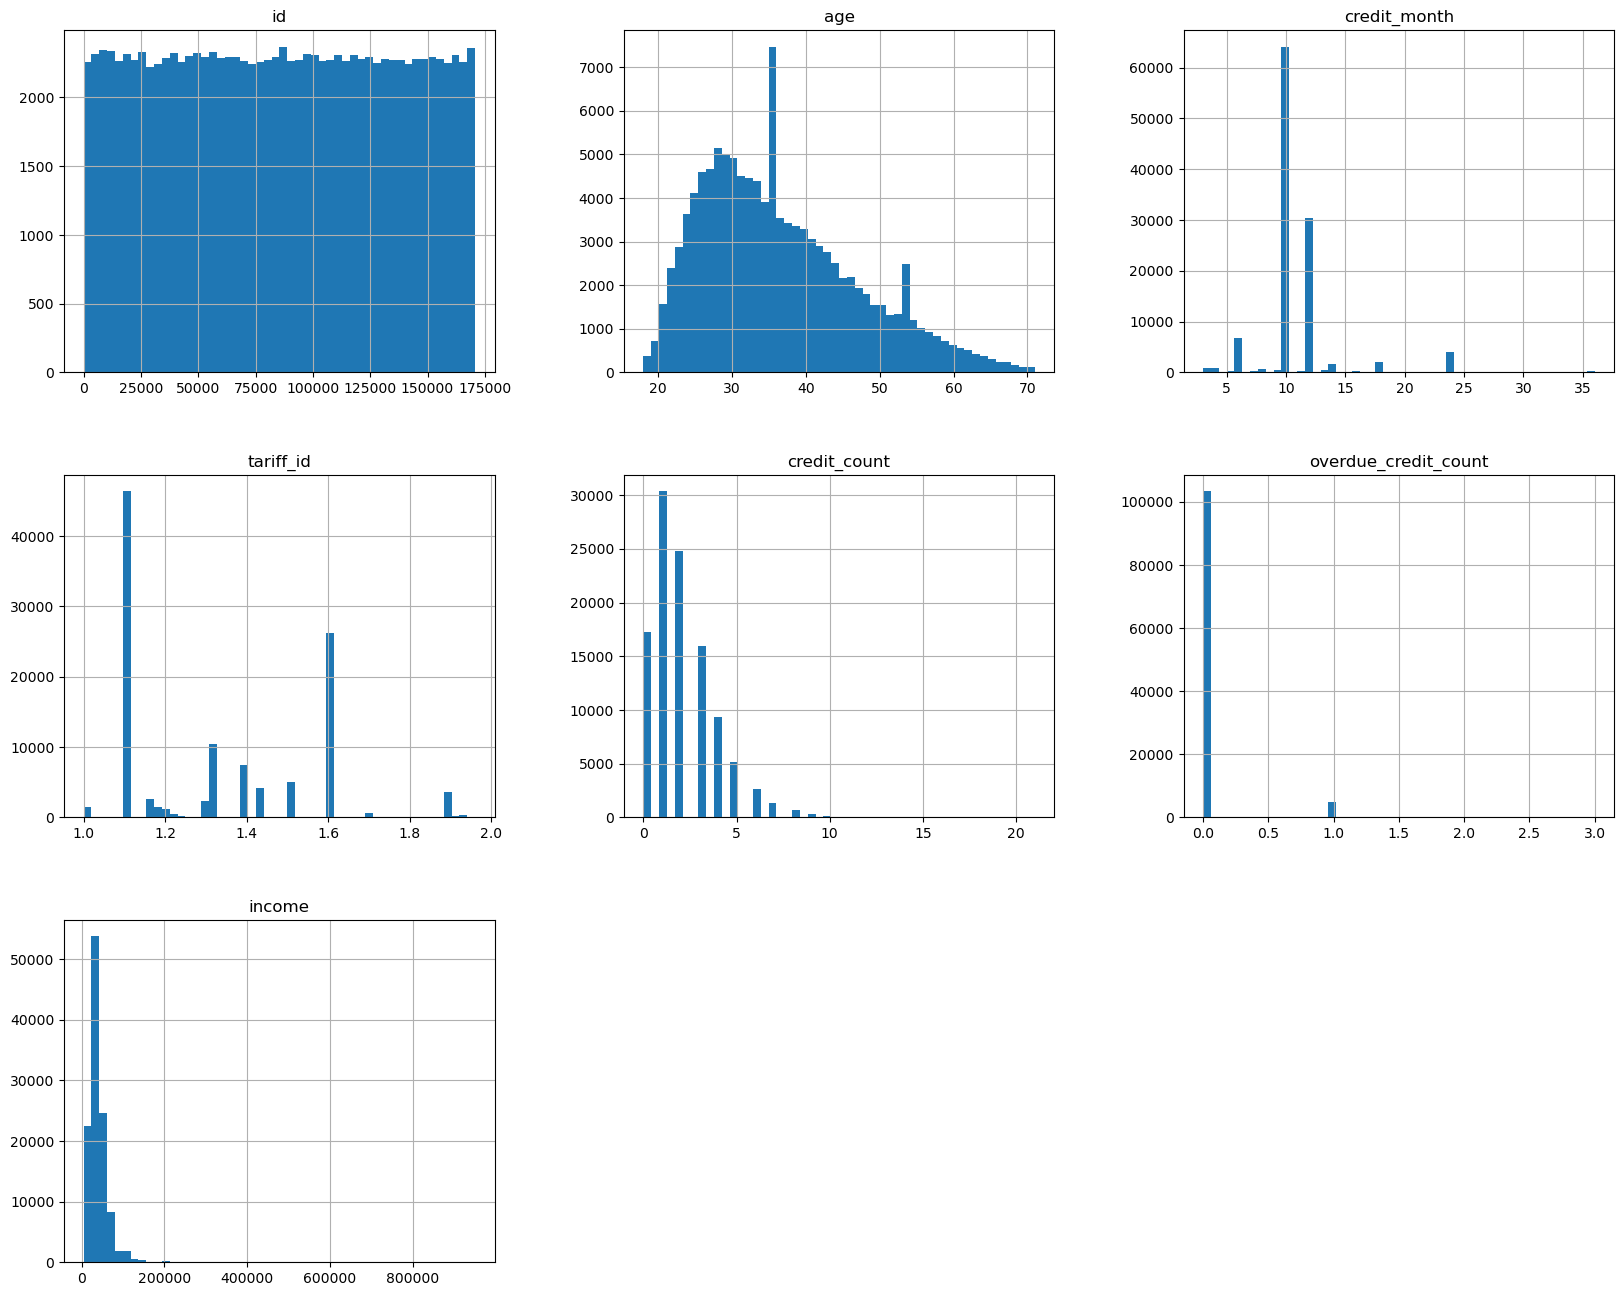

In [6]:
df_train.hist(bins=50, figsize=(20, 16))

Видим что некоторые "числа" записаны через запятую - не круто. Удалим id никакого смысла не несет :/
НО!!! tariff_id не выкидываем это номер тарифа поэтому может сослужит службу

Стратификацию делать стоит, потому что кроме credit_score все признаки распределены не ровно, поэтому стоит хоть как то выровнять выборку

In [7]:
df_train.drop(columns = ['id'], axis=1, inplace=True)
# df_test.drop(columns = ['id'], axis=1, inplace=True)
# df_train.drop(columns = ['tariff_id'], axis=1, inplace=True)
# df_test.drop(columns = ['tariff_id'], axis=1, inplace=True)

In [8]:
df_train

,gender,age,marital_status,credit_sum,credit_month,tariff_id,education,credit_count,overdue_credit_count,job_pos,credit_score,region,income,opened
0,M,24,UNM,"24000,00",10,1.60,SCH,2.0,0.0,SPC,"0,728851",ОБЛ ЛЕНИНГРАДСКАЯ,35000.0,True
1,M,23,UNM,"16339,00",18,1.10,SCH,2.0,0.0,SPC,"0,347385",МОСКВА Г,38000.0,True
2,M,54,UNM,"15652,00",10,1.32,GRD,2.0,0.0,SPC,"0,349705",ОБЛ МОСКОВСКАЯ,38000.0,True
3,F,52,UNM,"16560,00",10,1.10,SCH,1.0,0.0,SPC,"0,359232",РЕСП МОРДОВИЯ,28000.0,False
4,F,63,WID,"9078,00",18,1.10,SCH,4.0,0.0,SPC,"0,529368",ЧЕЛЯБИНСКАЯ ОБЛ,30000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,M,29,MAR,"29678,00",10,1.60,GRD,1.0,0.0,SPC,"0,721156",ОМСКАЯ ОБЛАСТЬ,25000.0,False
114395,M,29,MAR,"23068,00",15,1.10,GRD,3.0,0.0,SPC,"0,566393",ТЮМЕНСКАЯ ОБЛ,30000.0,True
114396,F,45,MAR,"16418,00",10,1.10,SCH,1.0,0.0,UMN,"0,327380",ОБЛ БРЯНСКАЯ,30400.0,False
114397,F,49,MAR,"12169,00",10,1.40,SCH,1.0,0.0,SPC,"0,467395",ТАМБОВСКАЯ ОБЛ,16000.0,False


In [9]:
df_train['credit_sum'] = df_train['credit_sum'].map(lambda x: x.replace(',', '.'))
df_train['credit_score'] = df_train['credit_score'].map(lambda x: x.replace(',', '.'))

df_train['credit_sum'] = df_train['credit_sum'].astype(dtype=np.float64)
df_train['credit_score'] = df_train['credit_score'].astype(dtype=np.float64)

df_train['opened'] = df_train['opened'].astype(dtype=np.int64)

In [10]:
df_test['credit_sum'] = df_test['credit_sum'].map(lambda x: x.replace(',', '.'))
df_test['credit_score'] = df_test['credit_score'].map(lambda x: x.replace(',', '.'))

df_test['credit_sum'] = df_test['credit_sum'].astype(dtype=np.float64)
df_test['credit_score'] = df_test['credit_score'].astype(dtype=np.float64)

In [11]:
df_test

,id,gender,age,marital_status,credit_sum,credit_month,tariff_id,education,credit_count,overdue_credit_count,job_pos,credit_score,region,income
0,39162,F,18,UNM,39469.0,6,1.44,GRD,NaN,NaN,SPC,0.424628,САНКТ-ПЕТЕРБУРГ Г,30000.0
1,10673,F,63,WID,16693.0,10,1.32,GRD,2.0,0.0,SPC,0.311945,ОБЛ ЛЕНИНГРАДСКАЯ,21250.0
2,121409,M,42,MAR,60260.0,10,1.10,GRD,5.0,0.0,SPC,0.421982,МОСКВА Г,150000.0
3,23504,M,41,MAR,32479.0,12,1.10,GRD,1.0,0.0,DIR,0.406572,ТАТАРСТАН РЕСП,150000.0
4,69269,F,24,UNM,8159.0,12,1.10,SCH,2.0,0.0,SPC,0.418243,ТВЕРСКАЯ ОБЛ,16000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56342,14148,F,21,UNM,40980.0,24,1.90,GRD,1.0,0.0,SPC,0.429402,САМАРСКАЯ,22000.0
56343,153732,M,56,MAR,16009.0,10,1.10,SCH,0.0,0.0,SPC,0.494229,САМАРСКАЯ ОБЛ,29000.0
56344,37647,M,54,MAR,22448.0,12,1.10,SCH,1.0,0.0,UMN,0.312089,РОСТОВСКАЯ ОБЛ,26500.0
56345,92808,F,27,UNM,13829.0,10,1.90,GRD,2.0,0.0,SPC,0.339009,ОБЛ СВЕРДЛОВСКАЯ,38000.0


## Выделим категориальные и числовые признаки

In [12]:
categorical_train = df_train.select_dtypes(include=[object]).astype(str)
number_train = df_train.select_dtypes(include=[int, float, bool])

In [13]:
categorical_train = pd.concat([categorical_train, number_train['tariff_id']], axis=1)
number_train.drop(columns=['tariff_id'], inplace=True)

In [14]:
categorical_train['tariff_id'] = categorical_train['tariff_id'].map(lambda x: str(x))

In [15]:
categorical_test = df_test.select_dtypes(include=[object]).astype(str)
number_test = df_test.select_dtypes(include=[int, float, bool])

In [16]:
categorical_test = pd.concat([categorical_test, number_test['tariff_id']], axis=1)
number_test.drop(columns=['tariff_id'], inplace=True)

In [17]:
categorical_train['tariff_id'] = categorical_train['tariff_id'].map(lambda x: str(x))
categorical_test['tariff_id'] = categorical_test['tariff_id'].map(lambda x: str(x))

In [18]:
categorical_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114399 entries, 0 to 114398
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   gender          114399 non-null  object
 1   marital_status  114399 non-null  object
 2   education       114399 non-null  object
 3   job_pos         114399 non-null  object
 4   region          114399 non-null  object
 5   tariff_id       114399 non-null  object
dtypes: object(6)
memory usage: 5.2+ MB


In [19]:
number_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114399 entries, 0 to 114398
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   age                   114399 non-null  int64  
 1   credit_sum            114399 non-null  float64
 2   credit_month          114399 non-null  int64  
 3   credit_count          108210 non-null  float64
 4   overdue_credit_count  108210 non-null  float64
 5   credit_score          114399 non-null  float64
 6   income                114399 non-null  float64
 7   opened                114399 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 7.0 MB


In [20]:
df_train.isna().sum()

gender                     0
age                        0
marital_status             0
credit_sum                 0
credit_month               0
tariff_id                  0
education                  0
credit_count            6189
overdue_credit_count    6189
job_pos                    0
credit_score               0
region                   132
income                     0
opened                     0
dtype: int64

In [21]:
number_test

,id,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income
0,39162,18,39469.0,6,NaN,NaN,0.424628,30000.0
1,10673,63,16693.0,10,2.0,0.0,0.311945,21250.0
2,121409,42,60260.0,10,5.0,0.0,0.421982,150000.0
3,23504,41,32479.0,12,1.0,0.0,0.406572,150000.0
4,69269,24,8159.0,12,2.0,0.0,0.418243,16000.0
...,...,...,...,...,...,...,...,...
56342,14148,21,40980.0,24,1.0,0.0,0.429402,22000.0
56343,153732,56,16009.0,10,0.0,0.0,0.494229,29000.0
56344,37647,54,22448.0,12,1.0,0.0,0.312089,26500.0
56345,92808,27,13829.0,10,2.0,0.0,0.339009,38000.0


In [22]:
categorical_test

,gender,marital_status,education,job_pos,region,tariff_id
0,F,UNM,GRD,SPC,САНКТ-ПЕТЕРБУРГ Г,1.44
1,F,WID,GRD,SPC,ОБЛ ЛЕНИНГРАДСКАЯ,1.32
2,M,MAR,GRD,SPC,МОСКВА Г,1.1
3,M,MAR,GRD,DIR,ТАТАРСТАН РЕСП,1.1
4,F,UNM,SCH,SPC,ТВЕРСКАЯ ОБЛ,1.1
...,...,...,...,...,...,...
56342,F,UNM,GRD,SPC,САМАРСКАЯ,1.9
56343,M,MAR,SCH,SPC,САМАРСКАЯ ОБЛ,1.1
56344,M,MAR,SCH,UMN,РОСТОВСКАЯ ОБЛ,1.1
56345,F,UNM,GRD,SPC,ОБЛ СВЕРДЛОВСКАЯ,1.9


In [23]:
categorical_test.isna().sum()

gender            0
marital_status    0
education         0
job_pos           0
region            0
tariff_id         0
dtype: int64

In [24]:
df_train['region'].value_counts()

region
ОБЛ МОСКОВСКАЯ                   8192
КРАСНОДАРСКИЙ КРАЙ               5010
САНКТ-ПЕТЕРБУРГ                  3751
МОСКВА                           3706
ТАТАРСТАН РЕСП                   3455
                                 ... 
ОБЛ.РОСТОВСКАЯ                      1
ОМСКАЯ                              1
РЕСП. КОМИ                          1
ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ       1
ТОМСКАЯ                             1
Name: count, Length: 284, dtype: int64

## Impute nans

In [25]:
imp_median = SimpleImputer(strategy='median')

In [26]:
number_test.replace([np.inf, -np.inf], 0, inplace=True)

In [27]:
number_train_imputed = pd.DataFrame(imp_median.fit_transform(number_train), columns=number_train.columns)
number_test_imputed = pd.DataFrame(imp_median.fit_transform(number_test), columns=number_test.columns)

In [28]:
number_test_imputed

,id,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income
0,39162.0,18.0,39469.0,6.0,2.0,0.0,0.424628,30000.0
1,10673.0,63.0,16693.0,10.0,2.0,0.0,0.311945,21250.0
2,121409.0,42.0,60260.0,10.0,5.0,0.0,0.421982,150000.0
3,23504.0,41.0,32479.0,12.0,1.0,0.0,0.406572,150000.0
4,69269.0,24.0,8159.0,12.0,2.0,0.0,0.418243,16000.0
...,...,...,...,...,...,...,...,...
56342,14148.0,21.0,40980.0,24.0,1.0,0.0,0.429402,22000.0
56343,153732.0,56.0,16009.0,10.0,0.0,0.0,0.494229,29000.0
56344,37647.0,54.0,22448.0,12.0,1.0,0.0,0.312089,26500.0
56345,92808.0,27.0,13829.0,10.0,2.0,0.0,0.339009,38000.0


In [29]:
categorical_train.fillna('ОБЛ МОСКОВСКАЯ', inplace=True)

In [30]:
categorical_test.fillna('ОБЛ МОСКОВСКАЯ', inplace=True)

## Normalize

In [31]:
# scaler = MinMaxScaler()

In [32]:
# number_train_imputed = pd.DataFrame(scaler.fit_transform(number_train_imputed), columns=number_train_imputed.columns)
# number_test = pd.DataFrame(scaler.fit_transform(number_test_imputed), columns=number_test_imputed.columns)

In [33]:
# number_train_imputed

In [34]:
# number_test

## New features

### Описание фичей
![image.png](attachment:image.png)

In [35]:
number_train_imputed.corr()['opened']

age                    -0.034788
credit_sum             -0.069257
credit_month            0.027354
credit_count            0.029789
overdue_credit_count    0.013779
credit_score            0.049692
income                 -0.021387
opened                  1.000000
Name: opened, dtype: float64

In [36]:
number_train_imputed[number_train_imputed['income'] > 30_000]['income'] = 30_000
number_test_imputed[number_test_imputed['income'] > 30_000]['income'] = 30_000

In [37]:
number_train_imputed

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,opened
0,24.0,24000.0,10.0,2.0,0.0,0.728851,35000.0,1.0
1,23.0,16339.0,18.0,2.0,0.0,0.347385,38000.0,1.0
2,54.0,15652.0,10.0,2.0,0.0,0.349705,38000.0,1.0
3,52.0,16560.0,10.0,1.0,0.0,0.359232,28000.0,0.0
4,63.0,9078.0,18.0,4.0,0.0,0.529368,30000.0,0.0
...,...,...,...,...,...,...,...,...
114394,29.0,29678.0,10.0,1.0,0.0,0.721156,25000.0,0.0
114395,29.0,23068.0,15.0,3.0,0.0,0.566393,30000.0,1.0
114396,45.0,16418.0,10.0,1.0,0.0,0.327380,30400.0,0.0
114397,49.0,12169.0,10.0,1.0,0.0,0.467395,16000.0,0.0


In [38]:
number_train_imputed['factor'] = number_train_imputed['income'] * number_train_imputed['credit_month'] / number_train_imputed['credit_sum']
number_test_imputed['factor'] = number_test_imputed['income'] * number_test_imputed['credit_month'] / number_test_imputed['credit_sum']

In [46]:
number_train_imputed['f1'] = number_train_imputed['income'] - number_train_imputed['credit_sum']
number_test_imputed['f1'] = number_test_imputed['income'] - number_test_imputed['credit_sum']

<Axes: xlabel='id', ylabel='f1'>

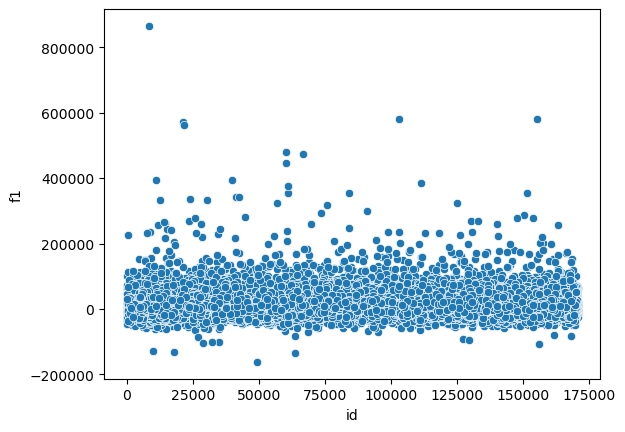

In [40]:
sns.scatterplot(data=number_test_imputed, y='f1', x='id')

In [51]:
number_train_imputed['f1_out_hi'] = (number_train_imputed['f1'] > 5010).map(int)
number_test_imputed['f1_out_hi'] = (number_test_imputed['f1'] > 5010).map(int)

In [52]:
number_train_imputed['f1_out_low'] = (number_train_imputed['f1'] > -16_000).map(int)
number_test_imputed['f1_out_low'] = (number_test_imputed['f1'] < -16_000).map(int)

In [55]:
number_train_imputed['credit_score_per_age'] = number_train_imputed['credit_score'] / number_train_imputed['age']
number_test_imputed['credit_score_per_age'] = number_test_imputed['credit_score'] / number_test_imputed['age']

In [57]:
number_train_imputed['credit_score_per_sum'] = number_train_imputed['credit_score'] / number_train_imputed['credit_sum']
number_test_imputed['credit_score_per_sum'] = number_test_imputed['credit_score'] / number_test_imputed['credit_sum']

In [59]:
number_train_imputed['factor_per_sum'] = number_train_imputed['factor'] / number_train_imputed['credit_sum']
number_test_imputed['factor_per_sum'] = number_test_imputed['factor'] / number_test_imputed['credit_sum']

In [53]:
number_train_imputed = number_train_imputed.drop('f1', axis=1)
number_test_imputed = number_test_imputed.drop('f1', axis=1)

In [62]:
number_train_imputed.corr()['opened'].sort_values()

credit_sum             -0.069257
age                    -0.034788
income                 -0.021387
f1_out_low              0.002199
overdue_credit_count    0.013779
credit_month            0.027354
credit_count            0.029789
f1_out_hi               0.035596
sum_per_factor          0.039073
factor                  0.048448
credit_score            0.049692
factor_per_sum          0.056024
credit_score_per_age    0.076342
credit_score_per_sum    0.103117
opened                  1.000000
Name: opened, dtype: float64

In [46]:
number_train_imputed

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,opened,factor,f1_out_hi,f1_out_low
0,24.0,24000.0,10.0,2.0,0.0,0.728851,35000.0,1.0,14.583333,1,1
1,23.0,16339.0,18.0,2.0,0.0,0.347385,38000.0,1.0,41.863027,1,1
2,54.0,15652.0,10.0,2.0,0.0,0.349705,38000.0,1.0,24.278048,1,1
3,52.0,16560.0,10.0,1.0,0.0,0.359232,28000.0,0.0,16.908213,1,1
4,63.0,9078.0,18.0,4.0,0.0,0.529368,30000.0,0.0,59.484468,1,1
...,...,...,...,...,...,...,...,...,...,...,...
114394,29.0,29678.0,10.0,1.0,0.0,0.721156,25000.0,0.0,8.423748,0,1
114395,29.0,23068.0,15.0,3.0,0.0,0.566393,30000.0,1.0,19.507543,1,1
114396,45.0,16418.0,10.0,1.0,0.0,0.327380,30400.0,0.0,18.516263,1,1
114397,49.0,12169.0,10.0,1.0,0.0,0.467395,16000.0,0.0,13.148163,0,1


In [47]:
number_test_imputed

,id,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,factor,f1_out_hi,f1_out_low
0,39162.0,18.0,39469.0,6.0,2.0,0.0,0.424628,30000.0,4.560541,0,0
1,10673.0,63.0,16693.0,10.0,2.0,0.0,0.311945,21250.0,12.729887,0,0
2,121409.0,42.0,60260.0,10.0,5.0,0.0,0.421982,150000.0,24.892134,1,0
3,23504.0,41.0,32479.0,12.0,1.0,0.0,0.406572,150000.0,55.420426,1,0
4,69269.0,24.0,8159.0,12.0,2.0,0.0,0.418243,16000.0,23.532296,1,0
...,...,...,...,...,...,...,...,...,...,...,...
56342,14148.0,21.0,40980.0,24.0,1.0,0.0,0.429402,22000.0,12.884334,0,1
56343,153732.0,56.0,16009.0,10.0,0.0,0.0,0.494229,29000.0,18.114810,1,0
56344,37647.0,54.0,22448.0,12.0,1.0,0.0,0.312089,26500.0,14.166073,0,0
56345,92808.0,27.0,13829.0,10.0,2.0,0.0,0.339009,38000.0,27.478487,1,0


Новые признак факторности оплаты кредита - бомба. За одно действие топовый признак)

## One-Hot Encode

In [51]:
categorical_train_encoded = pd.get_dummies(categorical_train).astype(dtype=np.int32)
categorical_test_encoded = pd.get_dummies(categorical_test).astype(dtype=np.int32)

In [52]:
categorical_train_encoded

,gender_F,gender_M,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID,education_ACD,education_GRD,education_PGR,...,tariff_id_1.48,tariff_id_1.5,tariff_id_1.52,tariff_id_1.56,tariff_id_1.6,tariff_id_1.7,tariff_id_1.9,tariff_id_1.91,tariff_id_1.94,tariff_id_1.96
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
114395,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
114396,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114397,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
categorical_test_encoded

,gender_F,gender_M,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID,education_ACD,education_GRD,education_PGR,...,tariff_id_1.43,tariff_id_1.44,tariff_id_1.48,tariff_id_1.5,tariff_id_1.52,tariff_id_1.6,tariff_id_1.7,tariff_id_1.9,tariff_id_1.91,tariff_id_1.94
0,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56342,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
56343,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56344,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56345,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## PolyNomial Features

In [112]:
poly = PolynomialFeatures(degree=3)

In [168]:
y_train = number_train_imputed['opened']

In [171]:
number_test_imputed_poly = pd.DataFrame(poly.fit_transform(number_test_imputed))
number_train_imputed_poly = pd.DataFrame(poly.fit_transform(number_train_imputed.drop(columns=['opened'])))

Concatenate 2 dataframes

In [172]:
df_train_prepared = pd.concat([number_train_imputed, categorical_train_encoded.astype(str)], axis=1).astype(dtype=float)
df_train_imputed = pd.concat([number_train_imputed.astype(dtype=float), categorical_train.astype(str)], axis=1)
df_train_poly = pd.concat([number_train_imputed_poly, categorical_train_encoded.astype(str), y_train], axis=1).astype(dtype=float)
df_train_poly_ne = pd.concat([number_train_imputed_poly, categorical_train.astype(str), y_train], axis=1)

In [173]:
df_test_prepared = pd.concat([number_test_imputed, categorical_test_encoded.astype(str)], axis=1).astype(dtype=float)
df_test_imputed = pd.concat([number_test_imputed, categorical_test.astype(dtype=str)], axis=1)
df_test_poly_ne = pd.concat([number_test_imputed_poly, categorical_test.astype(str)], axis=1)

In [174]:
df_train_poly

,0,1,2,3,4,5,6,7,8,9,...,tariff_id_1.5,tariff_id_1.52,tariff_id_1.56,tariff_id_1.6,tariff_id_1.7,tariff_id_1.9,tariff_id_1.91,tariff_id_1.94,tariff_id_1.96,opened
0,1.0,24.0,24000.0,10.0,2.0,0.0,0.728851,35000.0,14.583333,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,23.0,16339.0,18.0,2.0,0.0,0.347385,38000.0,41.863027,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,54.0,15652.0,10.0,2.0,0.0,0.349705,38000.0,24.278048,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,52.0,16560.0,10.0,1.0,0.0,0.359232,28000.0,16.908213,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,63.0,9078.0,18.0,4.0,0.0,0.529368,30000.0,59.484468,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,1.0,29.0,29678.0,10.0,1.0,0.0,0.721156,25000.0,8.423748,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
114395,1.0,29.0,23068.0,15.0,3.0,0.0,0.566393,30000.0,19.507543,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
114396,1.0,45.0,16418.0,10.0,1.0,0.0,0.327380,30400.0,18.516263,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114397,1.0,49.0,12169.0,10.0,1.0,0.0,0.467395,16000.0,13.148163,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
df_train_poly_ne

,0,1,2,3,4,5,6,7,8,9,...,283,284,285,gender,marital_status,education,job_pos,region,tariff_id,opened
0,1.0,24.0,24000.0,10.0,2.0,0.0,0.728851,35000.0,14.583333,1.0,...,1.0,1.0,1.0,M,UNM,SCH,SPC,ОБЛ ЛЕНИНГРАДСКАЯ,1.6,1.0
1,1.0,23.0,16339.0,18.0,2.0,0.0,0.347385,38000.0,41.863027,1.0,...,1.0,1.0,1.0,M,UNM,SCH,SPC,МОСКВА Г,1.1,1.0
2,1.0,54.0,15652.0,10.0,2.0,0.0,0.349705,38000.0,24.278048,1.0,...,1.0,1.0,1.0,M,UNM,GRD,SPC,ОБЛ МОСКОВСКАЯ,1.32,1.0
3,1.0,52.0,16560.0,10.0,1.0,0.0,0.359232,28000.0,16.908213,1.0,...,1.0,1.0,1.0,F,UNM,SCH,SPC,РЕСП МОРДОВИЯ,1.1,0.0
4,1.0,63.0,9078.0,18.0,4.0,0.0,0.529368,30000.0,59.484468,1.0,...,1.0,1.0,1.0,F,WID,SCH,SPC,ЧЕЛЯБИНСКАЯ ОБЛ,1.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114394,1.0,29.0,29678.0,10.0,1.0,0.0,0.721156,25000.0,8.423748,0.0,...,0.0,0.0,1.0,M,MAR,GRD,SPC,ОМСКАЯ ОБЛАСТЬ,1.6,0.0
114395,1.0,29.0,23068.0,15.0,3.0,0.0,0.566393,30000.0,19.507543,1.0,...,1.0,1.0,1.0,M,MAR,GRD,SPC,ТЮМЕНСКАЯ ОБЛ,1.1,1.0
114396,1.0,45.0,16418.0,10.0,1.0,0.0,0.327380,30400.0,18.516263,1.0,...,1.0,1.0,1.0,F,MAR,SCH,UMN,ОБЛ БРЯНСКАЯ,1.1,0.0
114397,1.0,49.0,12169.0,10.0,1.0,0.0,0.467395,16000.0,13.148163,0.0,...,0.0,0.0,1.0,F,MAR,SCH,SPC,ТАМБОВСКАЯ ОБЛ,1.4,0.0


## Stratified shuffle

Применим стратификацию, потому что выборка явно не сбалансированная

In [58]:
split = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=42)
for train_index, test_index in split.split(df_train_imputed, df_train_imputed['opened']):
    strat_train_set = df_train_imputed.loc[train_index]
    strat_test_set = df_train_imputed.loc[test_index]

In [59]:
y = strat_train_set['opened']
X = strat_train_set.drop(columns=['opened'], axis=1)

In [60]:
X.replace([np.inf, -np.inf], 0, inplace=True)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# ML

## LogisticRegression

In [62]:
lr = LogisticRegression(dual=False, max_iter=2_000_000, n_jobs=-1, multi_class='ovr')

In [63]:
params = {
    'C': np.arange(2, 20, 0.1),
    'penalty': ['l2'],
    'solver': ['newton-cholesky'],
    # 'l1_ratio': [0.1, 0.5, 1],
}

In [64]:
gs = GridSearchCV(lr, params, scoring='f1', n_jobs=-1, cv=5, verbose=2)

In [65]:
# gs.fit(X_strat, y_strat)

In [66]:
# gs.best_score_, gs.best_params_

Логистическая регрессия не оправдала надежд) Забудем как страшный сон)))

## Бустинг

### XGB

In [67]:
bst = XGBClassifier(n_jobs=-1, max_depth=10, learning_rate=0.01, objective='binary:logistic')

In [68]:
# bst.fit(X_train, y_train)

In [69]:
# f1_score(y_test, bst.predict(X_test))

### CatBoost + Optuna

In [70]:
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)

In [71]:
class_weights = dict(zip(classes, weights))
class_weights

{0.0: 0.6070751024848429, 1.0: 2.8348098129104202}

In [176]:
y = df_train_poly_ne['opened']
X = df_train_poly_ne.drop(columns=['opened'], axis=0)

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [178]:
y.isna().sum()

0

In [179]:
def objective(trial):
    categorical_features_indices = np.where(X_train.dtypes != float)[0]
    class_weights = dict()
    class_weights[0.0] = trial.suggest_float("0", 0.0, 2)
    class_weights[1.0] = trial.suggest_float("1", 2, 5.0)
    param = {
        "iterations": trial.suggest_int("iterations", 100, 5_000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1e-7, 100.0),
        "border_count": trial.suggest_int("border_count", 1, 200),
        "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0),
        "max_ctr_complexity": trial.suggest_int("max_ctr_complexity", 1, 5),
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 3, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        # "used_ram_limit": "3gb",
        "class_weights": class_weights,
    }
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)],verbose=0, early_stopping_rounds=100, cat_features=categorical_features_indices)

    preds = cat_cls.predict(X_test)
    f1 = f1_score(y_test, preds)
    return f1

In [180]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

[I 2023-05-09 22:23:37,565] A new study created in memory with name: catboost
[I 2023-05-09 22:23:41,648] Trial 0 finished with value: 0.4365709004082261 and parameters: {'0': 0.834044009405148, '1': 4.160973480326474, 'iterations': 100, 'learning_rate': 0.3030302400592079, 'l2_leaf_reg': 14, 'border_count': 19, 'random_strength': 1.8626021219141067, 'max_ctr_complexity': 2, 'objective': 'Logloss', 'colsample_bylevel': 0.0457090726807603, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'od_type': 'IncToDec', 'od_wait': 32, 'subsample': 0.2263482447357104}. Best is trial 0 with value: 0.4365709004082261.
[I 2023-05-09 22:23:57,030] Trial 1 finished with value: 0.37025781289570986 and parameters: {'0': 0.3962029781697576, '1': 4.40223370602661, 'iterations': 4900, 'learning_rate': 0.3141107539810836, 'l2_leaf_reg': 69, 'border_count': 176, 'random_strength': 8.946066636092407, 'max_ctr_complexity': 1, 'objective': 'Logloss', 'colsample_bylevel': 0.013514930490959413,

KeyboardInterrupt: 

In [145]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  50
Best trial:
  Value:  0.4428616650838873
  Params: 
    0: 0.7056537331534757
    1: 3.3571248273283825
    iterations: 1300
    learning_rate: 0.15338476359786637
    l2_leaf_reg: 27
    border_count: 29
    random_strength: 8.716853955952907
    max_ctr_complexity: 3
    objective: Logloss
    colsample_bylevel: 0.040312119516962897
    depth: 5
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    od_type: IncToDec
    od_wait: 10
    subsample: 0.5718804844754448


In [91]:
model_cat = CatBoostClassifier(iterations=5000, learning_rate=0.11940497202475919, l2_leaf_reg=24,
                               border_count=29, random_strength=1.157805578520283, max_ctr_complexity=3,
                               objective="MultiClassOneVsAll", colsample_bylevel=0.05471262905092343, depth=12,
                               boosting_type="Ordered", bootstrap_type="MVS", od_type="IncToDec", od_wait=49,
                               class_weights={0.0: 0.6839608048648429, 1.0: 2.815738232726129})
model_cat.fit(X, y, verbose=True, plot=True, cat_features=np.where(X.dtypes != float)[0])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6927032	total: 19.6ms	remaining: 1m 37s
1:	learn: 0.6809986	total: 87.9ms	remaining: 3m 39s
2:	learn: 0.6800116	total: 115ms	remaining: 3m 11s
3:	learn: 0.6798125	total: 142ms	remaining: 2m 57s
4:	learn: 0.6746198	total: 174ms	remaining: 2m 53s
5:	learn: 0.6745017	total: 189ms	remaining: 2m 37s
6:	learn: 0.6744101	total: 205ms	remaining: 2m 26s
7:	learn: 0.6743390	total: 229ms	remaining: 2m 22s
8:	learn: 0.6730352	total: 250ms	remaining: 2m 18s
9:	learn: 0.6729926	total: 265ms	remaining: 2m 12s
10:	learn: 0.6729595	total: 284ms	remaining: 2m 9s
11:	learn: 0.6713672	total: 304ms	remaining: 2m 6s
12:	learn: 0.6713474	total: 321ms	remaining: 2m 3s
13:	learn: 0.6704029	total: 346ms	remaining: 2m 3s
14:	learn: 0.6703910	total: 362ms	remaining: 2m
15:	learn: 0.6689346	total: 386ms	remaining: 2m
16:	learn: 0.6689276	total: 403ms	remaining: 1m 58s
17:	learn: 0.6663239	total: 427ms	remaining: 1m 58s
18:	learn: 0.6663197	total: 447ms	remaining: 1m 57s
19:	learn: 0.6663165	total: 468m

In [99]:
X_test

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,factor,f1_out_hi,f1_out_low,gender,marital_status,education,job_pos,region,tariff_id
39786,43.0,22491.00,12.0,1.0,0.0,0.531093,45000.0,24.009604,1.0,1.0,M,MAR,SCH,SPC,ОБЛ МОСКОВСКАЯ,1.9
6381,33.0,27754.44,10.0,1.0,0.0,0.371411,55000.0,19.816649,1.0,1.0,F,UNM,GRD,SPC,ОБЛ МОСКОВСКАЯ,1.32
28601,32.0,7988.64,12.0,3.0,0.0,0.474971,20000.0,30.042661,1.0,1.0,F,UNM,GRD,SPC,САМАРСКАЯ ОБЛ,1.7
3446,32.0,15282.00,10.0,2.0,0.0,0.514811,25000.0,16.359115,1.0,1.0,F,MAR,GRD,SPC,САМАРСКАЯ ОБЛАСТЬ,1.16
89108,24.0,18389.00,12.0,1.0,0.0,0.320149,35000.0,22.839741,1.0,1.0,M,UNM,UGR,SPC,ОБЛ ЧЕЛЯБИНСКАЯ,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24235,52.0,17473.00,10.0,2.0,0.0,0.403353,30000.0,17.169347,1.0,1.0,M,UNM,SCH,SPC,УДМУРТСКАЯ РЕСП,1.32
4141,35.0,8500.00,6.0,6.0,0.0,0.309624,35000.0,24.705882,1.0,1.0,F,CIV,GRD,SPC,САНКТ-ПЕТЕРБУРГ,1.1
31964,55.0,23308.00,10.0,1.0,0.0,0.345412,30000.0,12.871117,1.0,1.0,M,MAR,SCH,BIS,ОБЛ МОСКОВСКАЯ,1.1
69063,29.0,15679.00,10.0,2.0,0.0,0.464153,33000.0,21.047261,1.0,1.0,M,MAR,GRD,SPC,ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ,1.1


In [100]:
y_test

39786    1.0
6381     0.0
28601    0.0
3446     0.0
89108    0.0
        ... 
24235    1.0
4141     1.0
31964    0.0
69063    0.0
59618    0.0
Name: opened, Length: 30202, dtype: float64

In [101]:
f1_score(y_test, model_cat.predict(X_test))

0.4925175473447226

In [102]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, model_cat.predict(X_test))

0.7320300834497789

In [103]:
model_cat.save_model('catboost.cbm')

# Save results

In [104]:
bst = model_cat

In [105]:
X_test = df_test_imputed.drop(columns=['id'], axis=1)

In [106]:
X_test

,age,credit_sum,credit_month,credit_count,overdue_credit_count,credit_score,income,factor,f1_out_hi,f1_out_low,gender,marital_status,education,job_pos,region,tariff_id
0,18.0,39469.0,6.0,2.0,0.0,0.424628,30000.0,4.560541,0,0,F,UNM,GRD,SPC,САНКТ-ПЕТЕРБУРГ Г,1.44
1,63.0,16693.0,10.0,2.0,0.0,0.311945,21250.0,12.729887,0,0,F,WID,GRD,SPC,ОБЛ ЛЕНИНГРАДСКАЯ,1.32
2,42.0,60260.0,10.0,5.0,0.0,0.421982,150000.0,24.892134,1,0,M,MAR,GRD,SPC,МОСКВА Г,1.1
3,41.0,32479.0,12.0,1.0,0.0,0.406572,150000.0,55.420426,1,0,M,MAR,GRD,DIR,ТАТАРСТАН РЕСП,1.1
4,24.0,8159.0,12.0,2.0,0.0,0.418243,16000.0,23.532296,1,0,F,UNM,SCH,SPC,ТВЕРСКАЯ ОБЛ,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56342,21.0,40980.0,24.0,1.0,0.0,0.429402,22000.0,12.884334,0,1,F,UNM,GRD,SPC,САМАРСКАЯ,1.9
56343,56.0,16009.0,10.0,0.0,0.0,0.494229,29000.0,18.114810,1,0,M,MAR,SCH,SPC,САМАРСКАЯ ОБЛ,1.1
56344,54.0,22448.0,12.0,1.0,0.0,0.312089,26500.0,14.166073,0,0,M,MAR,SCH,UMN,РОСТОВСКАЯ ОБЛ,1.1
56345,27.0,13829.0,10.0,2.0,0.0,0.339009,38000.0,27.478487,1,0,F,UNM,GRD,SPC,ОБЛ СВЕРДЛОВСКАЯ,1.9


In [107]:
np.where(X_test.dtypes != float)[0]

array([ 8,  9, 10, 11, 12, 13, 14, 15])

In [108]:
y_pred = bst.predict(X_test)

In [109]:
df_save = df_test[['id']]
df_save['opened'] = y_pred.astype(bool)

In [110]:
df_save

,id,opened
0,39162,True
1,10673,True
2,121409,False
3,23504,False
4,69269,True
...,...,...
56342,14148,False
56343,153732,False
56344,37647,False
56345,92808,False


In [111]:
df_save.to_csv('my_submission.csv', index=False)